<a href="https://colab.research.google.com/github/washpereiraa/DesafioPrime/blob/main/AMZN_Alta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Criei um **reposotorio no gitHub** para compartilhamento e controle dos arquivos gerados.
2. Criei **pasta para controle de alteração** dos arquivos, procurando preservar os dados originais e rastrear alteraçoes para possivel resgate de informações. As pastas foram nomeadas como: Arquivo Original, Alterações, Finalizado.
3. **No execel: **
    3.1 troquei a virgulo por pontos
    3.2 Exclusão das linhas 2742 a 2882 por conter muitos valores [\n] (not a number) a partir da coluna D, AE, AF, AG, AH, AI, AJ, AP, AR, AS, AT, AU, AV, AW, BB, BC, BE, BF, BG, BH, BJ, BK, BL, BM, CG, CK, CL, CM, CO, CR e CS
4.** No Visual estudio** criei um projeto de ETL para tratar dados em massa
    4.1 Conexão com bando de dados local (DS_AZMN)
    4.2 Explorando o banco em busca de anomalias (exclui linhas com dados NULL)
5. Adescrição das questão proposta, orienta usar a criatividade para a solução do problema, por esse motivo e por que o data deset fornecido apresenta diversas incosistencias que e falta de clareza em algumas informações. Decidi buscar uma fonte de dados segura da compania AMZN (Amazon) no site do Yahoo Finanças disponibilizado pelo link (https://finance.yahoo.com/quote/AMZN/history?period1=1262563200&period2=1609372800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) no mesmo perido do dateset fornecido no email (04-01-2010 a 30-12-2020)

In [26]:
#importando bibliotecas

#pandas
import pandas as pd

#Bibliotecas de Machine Learning
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression 

#treinamento e teste
from sklearn.model_selection import train_test_split

#Relatorios/Metricas
from sklearn.metrics import r2_score, classification_report, confusion_matrix

#graficos/plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
dfAmazon = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AMZN.csv")
dfAmazon.shape

(2768, 7)

In [28]:
#O campo data esta em object/string, por isso irei converter um tipo data
dfAmazon['Date'] = pd.to_datetime(dfAmazon['Date'], infer_datetime_format=True)
dfAmazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2768 non-null   datetime64[ns]
 1   Open       2768 non-null   float64       
 2   High       2768 non-null   float64       
 3   Low        2768 non-null   float64       
 4   Close      2768 non-null   float64       
 5   Adj Close  2768 non-null   float64       
 6   Volume     2768 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 151.5 KB


In [29]:
#Cauculando a media movel para 5 e 10 dias

dfAmazon['MM 5 dias'] = dfAmazon['Adj Close'].rolling(5).mean()
dfAmazon['MM 10 dias'] = dfAmazon['Adj Close'].rolling(10).mean()

dfAmazon.shape

(2768, 9)

In [30]:
#dfAmazon = dfAmazon.drop(columns = ['Media Movel = 10 dias'])
dfAmazon.shape


(2768, 9)

In [31]:
#Empurando 1 dia a frente para prever os valores

dfAmazon['Adj Close'] = dfAmazon['Adj Close'].shift(-1)
dfAmazon.tail(10)
dfAmazon.shape


(2768, 9)

In [32]:
#Excluindo valores NAN

dfAMZN = dfAmazon.dropna()
dfAMZN.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MM 5 dias,MM 10 dias
9,2010-01-15,129.179993,129.649994,127.059998,127.139999,127.610001,15376500,128.251999,130.561999
10,2010-01-19,126.309998,128.000000,124.330002,127.610001,125.779999,8892600,127.711999,129.933000
11,2010-01-20,127.129997,129.199997,125.080002,125.779999,126.620003,9074700,127.398000,129.042000
12,2010-01-21,127.260002,128.149994,125.000000,126.620003,121.430000,9970600,126.900000,128.479000
13,2010-01-22,125.599998,127.669998,120.760002,121.430000,120.309998,11568900,125.716000,127.622000


In [33]:
len(dfAMZN)
#len(dfAMZN)

2758

In [34]:
#Reindexando o data Frame

#dfAmazon = dfAmazon.reset_index(drop = True)
#dfAmazon.head()

In [35]:
#separando features e labels

features = dfAMZN.drop(['Date', 'Close', 'Adj Close'], 1)
Label = dfAMZN['Adj Close']


In [36]:
#Escolhendo melhores features

featuresList = ('Open',	'High', 'Low',	'Volume',	'MM 5 dias',	'MM 10 dias')

bestFeatures = SelectKBest(k='all')
bestFeatures.fit_transform(features, Label)
#bestFeaturesScores = bestFeatures.scores_
rawPairs = zip(featuresList[0:], bestFeatures.scores_)
#ordenar pares
orderedPairs = list(reversed(sorted(rawPairs, key = lambda x: x[1])))

#melhores keys/features
bestFeaturesFinal = dict(orderedPairs)
print('Melhores \n', bestFeaturesFinal)


Melhores 
 {'High': 1591.0656892228521, 'Open': 1129.31574069071, 'Low': 1032.811519972679, 'MM 5 dias': 1030.9720035773723, 'MM 10 dias': 797.9536423815468, 'Volume': 0.40079534930539534}


In [37]:
#Novas Features baseada nos algoritmos acima

newFeatures = features.drop(['Volume'], 1)
newFeatures.head()


,Open,High,Low,MM 5 dias,MM 10 dias
9,129.179993,129.649994,127.059998,128.251999,130.561999
10,126.309998,128.000000,124.330002,127.711999,129.933000
11,127.129997,129.199997,125.080002,127.398000,129.042000
12,127.260002,128.149994,125.000000,126.900000,128.479000
13,125.599998,127.669998,120.760002,125.716000,127.622000


In [38]:
#Normalizando/balanceando os dados

scaler = MinMaxScaler().fit(newFeatures)
featuresScaler = scaler.transform(newFeatures)

print('Features \n', featuresScaler.shape, '\n ', featuresScaler)

Features 
 (2758, 5) 
  [[0.00675662 0.00533572 0.00628828 0.00557086 0.00526808]
 [0.00592258 0.0048562  0.00548081 0.00540952 0.00507695]
 [0.00616087 0.00520494 0.00570264 0.00531571 0.00480621]
 ...
 [0.89738654 0.89821155 0.90603363 0.92166138 0.93455111]
 [0.89741563 0.92785444 0.90712505 0.92657973 0.93964204]
 [0.93110862 0.94141167 0.93922607 0.93350044 0.9446567 ]]


In [39]:
#Separando dados de Treino e de teste
#80% de treino e 20% de teste

# x = featuresScaler
# y = Label

# xTrain, xTeste = featuresScaler
# yTrain, YTeste = Label

#separando dados comprar o predict futuramente, no codigo abaixo
# validacaoDados = len(featuresScaler) - 10 = 2748
# len(featuresScaler) = 2758 
# len(dfAmazon) = 2758

#treino/aprendizado
xTrain, xTest, yTrain, yTest = train_test_split(featuresScaler, Label, test_size = 0.20)

In [40]:
len(xTrain)

2206

In [41]:
#Aprendizado - almoritmo de Regressão linear

regressaoLinear = LinearRegression()
regressaoLinear.fit(xTrain, yTrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
#predição - Regressão Linear

predict = regressaoLinear.predict(xTest)

In [43]:
#Metricas e Relatorios

print('Coeficiente de Determinação \n', (r2_score(yTest, predict)) * 100)

Coeficiente de Determinação 
 99.89568848925487


In [44]:
#Aprendizado - almoritmo de Rede Neural

redeNeural = MLPRegressor()
redeNeural.fit(xTrain, yTrain)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [45]:
#predição - Rede Neural

predict2 = redeNeural.predict(xTest)

In [46]:
#Metricas e Relatorios de Rede Neural

print('Coeficiente de Determinação \n', (r2_score(yTest, predict2)) * 100)


Coeficiente de Determinação 
 72.5691572267439


In [47]:
#Executando a preveisão

#seperando os dados que foram preditos
previsao = featuresScaler[2749:2768]

#obtendo as datas
dataPregaoFull = dfAMZN['Date']

#separando as datas
dataPregao = dataPregaoFull[2749:2768]

#obtendo todos os preços de fechamento
precoFechamentoFull = dfAMZN['Adj Close']

#separando os preços de fechamento
precoFechamento = precoFechamentoFull[2749:2768]

#variavel predict da regressão linear
pred = regressaoLinear.predict(previsao)

#Criando DataFrame dos dados separados
dfPrevisao = pd.DataFrame({'Data Pregao': dataPregao, 'Preco Fechamento': precoFechamento, 'Previsao': pred})

#retornando o shift para posição original
dfPrevisao['Preco Fechamento'] = dfPrevisao['Preco Fechamento'].shift(+1)

#setar index
dfPrevisao.set_index('Data Pregao', inplace = True)

dfPrevisao.head(10)


,Preco Fechamento,Previsao
Data Pregao,,
2020-12-16,NaN,3236.914878
2020-12-17,3236.080078,3240.280049
2020-12-18,3201.649902,3190.620614
2020-12-21,3206.179932,3207.851715
2020-12-22,3206.520020,3215.202680
2020-12-23,3185.270020,3205.027316
2020-12-24,3172.689941,3192.202899
2020-12-28,3283.959961,3285.352112
2020-12-29,3322.000000,3322.749327


In [48]:
dfAmazon[2747:2769]

,Date,Open,High,Low,Close,Adj Close,Volume,MM 5 dias,MM 10 dias
2747,2020-12-01,3188.500000,3248.949951,3157.179932,3220.080078,3203.530029,4544400,3177.318066,3144.252002
2748,2020-12-02,3221.649902,3232.000000,3173.260010,3203.530029,3186.729980,3129300,3194.412060,3151.039014
2749,2020-12-03,3205.459961,3228.639893,3181.310059,3186.729980,3162.580078,2892000,3194.744043,3159.166016
2750,2020-12-04,3198.209961,3198.209961,3158.760010,3162.580078,3158.000000,2913600,3188.192041,3163.722021
2751,2020-12-07,3156.479980,3180.760010,3141.689941,3158.000000,3177.290039,2751300,3186.184033,3169.582031
2752,2020-12-08,3158.899902,3184.129883,3120.020020,3177.290039,3104.199951,3286300,3177.626025,3177.472046
2753,2020-12-09,3167.889893,3174.429932,3088.000000,3104.199951,3101.489990,4100800,3157.760010,3176.086035
2754,2020-12-10,3088.989990,3142.100098,3076.000000,3101.489990,3116.419922,3030200,3140.712012,3167.728027
2755,2020-12-11,3096.659912,3118.669922,3072.820068,3116.419922,3156.969971,3064700,3131.479980,3159.836011
2756,2020-12-14,3143.000000,3190.469971,3126.000000,3156.969971,3165.120117,4155800,3131.273975,3158.729004


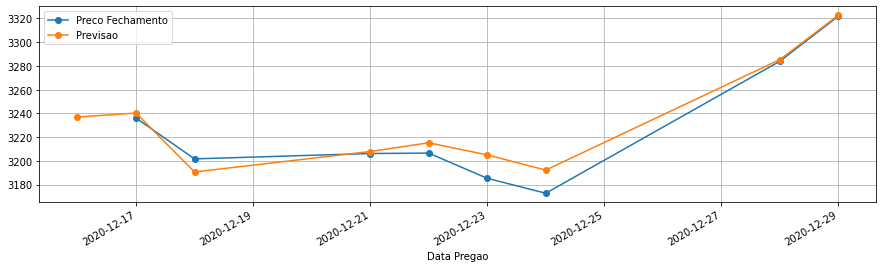

In [49]:
#Representação grafica

columns = ['Preco Fechamento', 'Previsao']
graph = dfPrevisao[columns].plot(figsize=(15, 4), grid=True, marker = 'o')

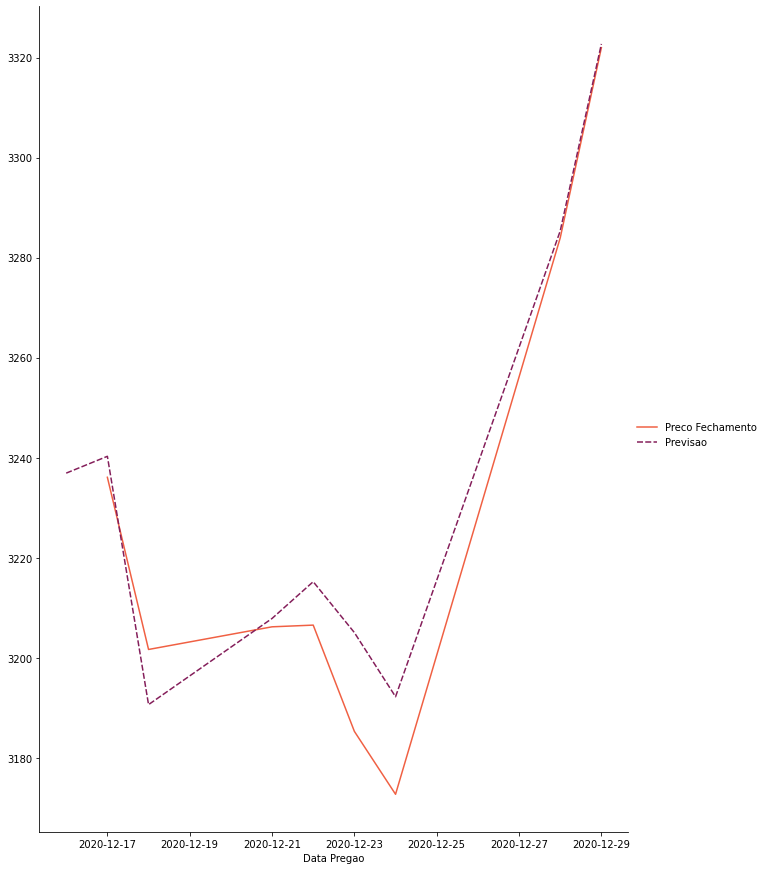

In [50]:
sns.relplot(
    data=dfPrevisao,
    kind="line", palette='rocket_r',
    height = 12, aspect=.75, facet_kws=dict(sharex=False),
)